# Post-stack seismic inversion of SEAM model with IntraSeismic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pylops
from pylops.utils.wavelets import *
from intraseismic.utils import *
from intraseismic.dataset import *
from intraseismic.model import *
from intraseismic.train import *
from torchinfo import summary
import torch
import json
from torch.utils.data import DataLoader


plt.rcParams['font.size'] = '9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

True

## Data Loading

(<Figure size 700x560 with 4 Axes>,
 (<AxesSubplot:xlabel='x samples', ylabel='t samples'>,
  <AxesSubplot:ylabel='y samples'>,
  <AxesSubplot:xlabel='y samples'>))

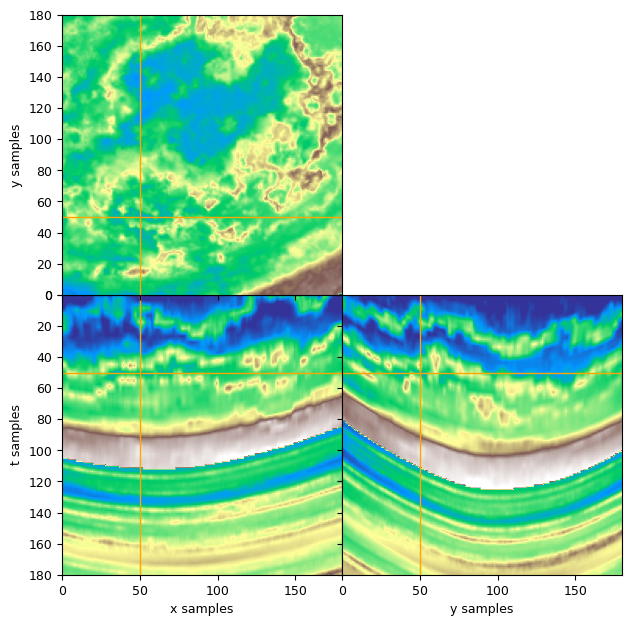

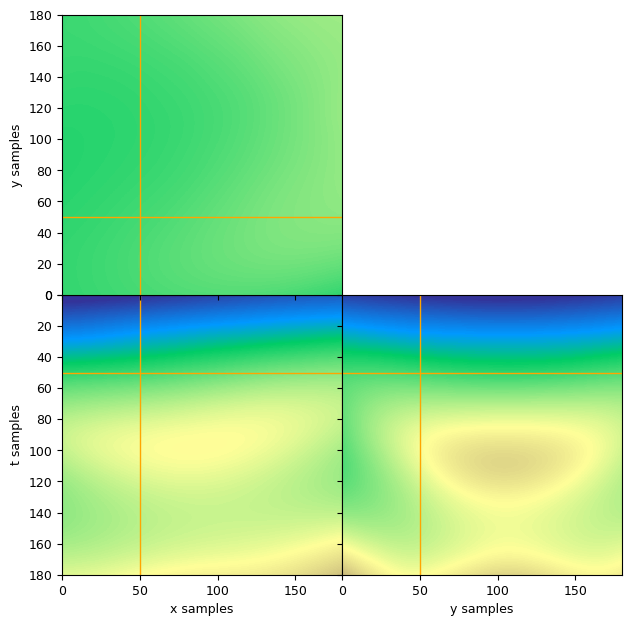

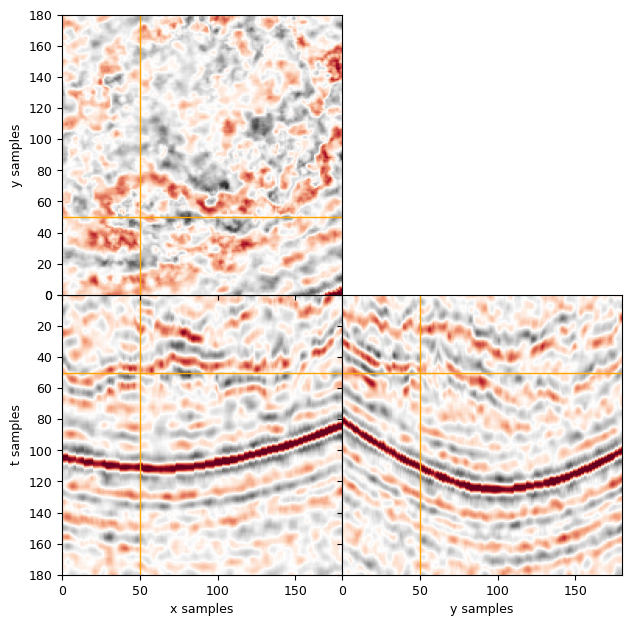

In [2]:
seam = np.load('../../data/SEAM.npz')

# Limits 
xmin, xmax = 20,200
ymin, ymax = 20, -1
zmin, zmax = 120, -1

d_tensor = torch.from_numpy(seam['dn1']).float()[zmin:, ymin:, xmin:xmax].ravel()
m_true_ = seam['m_true'][zmin:, ymin:, xmin:xmax]
m_true = torch.from_numpy(np.exp(seam['m_true']).astype('float32'))[zmin:, ymin:, xmin:xmax]
mback = torch.from_numpy(seam['mback']).float()[zmin:, ymin:, xmin:xmax]
wav = seam['wav']
vmin, vmax = np.percentile(m_true, [2, 98])

dims = mback.shape

# # Visualization
i, j, k = 50, 50, 50
explode_volume(m_true, i, j, k, figsize=(7, 5.6), cmap='terrain', vmin=vmin, vmax=vmax)
explode_volume(np.exp(mback), i, j, k, figsize=(7, 5.6), cmap='terrain', vmin=vmin, vmax=vmax)
explode_volume(d_tensor.reshape(*dims), i, j, k, figsize=(7, 5.6),vmin=-0.05, vmax=0.05, cmap='RdGy')

## Data preparation

In [3]:
opt_type = 'single-batch' 
# opt_type = 'mini-batch'

coords = create_coords(dims)

# General parameters
num_epochs = 400
print_evry = 100
learning_rate = 1e-2

# Parameters
if opt_type == 'mini-batch':
    batch_size = 64
    window_size = 64
    overlap = 32
    dims_mb = (window_size, window_size) if len(dims) == 2 else (window_size, window_size, window_size)
    # For mini-batches
    dataset_ = torch.cat((coords, d_tensor.unsqueeze(1), mback.ravel().unsqueeze(1)), dim=1)
    subvol = windows(dataset_.T.reshape(dataset_.shape[1], *dims), window_size=window_size, overlap=overlap) # for structured windows
    # subvol = windows_rand(dataset_.T.reshape(dataset_.shape[1], *dims), window_size=64, N=64)    # for randomly selected windows
    print(f'Number of subvolumes : {subvol.shape[0]}')
    dataset_batches = WinDataset(subvol)
    last_batch_size = len(dataset_batches) - batch_size *(len(dataset_batches) // batch_size)
    dataloader = DataLoader(dataset_batches, batch_size=batch_size, shuffle=True)

    # Modeling Operators for minibatches
    G = pylops.avo.poststack.PoststackLinearModelling(wav/ 2, nt0=window_size, spatdims=dims_mb[1:])
    Gf = create_block_diagonal(G, batch_size) # Operator for the first batches
    G_torch = pylops.torchoperator.TorchOperator(Gf, device=device) # torch operator
    Gl = create_block_diagonal(G, last_batch_size) # Operator for the last batch
    G_torch2 = pylops.torchoperator.TorchOperator(Gl, device=device)
    
elif opt_type == 'single-batch':  
    coords = coords.to(device)
    d =  d_tensor.to(device)
    mback_ =  mback.ravel().to(device)
    G = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=dims[0], spatdims=dims[1:])
    G_torch = pylops.torchoperator.TorchOperator(G, device=device) # torch operator

## IntraSeismic model setup

In [4]:
# IntraSeismic model setup
with open("config_seam.json") as f:
	config = json.load(f)
    
# IntraSeismic network 
net = create_model(n_input_dims=len(dims), n_output_dims=1, config=config).to(device)
print(net)
summary(net)

Sequential(
  (0): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 20, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 16, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.059999942779541, 'type': 'Hash'})
  (1): MLP(
    (layers_linears): ModuleList(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
    (output_linear): Linear(in_features=64, out_features=1, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Encoding: 1-1                          1,143,664
├─MLP: 1-2                               --
│    └─ModuleList: 2-1                   --
│    │    └─Linear: 3-1                  2,112
│    │    └─Linear: 3-2                  4,160
│    └─Linear: 2-2                       65
Total params: 1,150,001
Trainable params: 1,150,001
Non-trainable params: 0

## Training

In [5]:
# Initialize optimizer and losses
combined_parameters = list(net.parameters())
optimizer = torch.optim.Adam(combined_parameters, lr=learning_rate)

# Training Loop
total_train_time = 0
epoch_losses = []
snrs = []

for epoch in range(1, num_epochs + 1):
    net.train()
    if opt_type == 'mini-batch':
        loss, epoch_time = train_is_mb(dataloader, dims_mb, 
                                       G_torch, G_torch2,
                                       net, optimizer,
                                       alpha_mtv = 1e-9,
                                       beta = 1e-4)
                                                                                           
        total_train_time += epoch_time
        epoch_losses.append(loss)
    
    elif opt_type == 'single-batch':
        loss, epoch_time = train_is_sb(coords, d, mback_, dims, G_torch,
                                       net, optimizer,
                                       alpha_mtv = 1e-9,
                                       beta = 1e-4)
                                                                                           
        total_train_time += epoch_time
        epoch_losses.append(loss)    
        
    net.eval()
    with torch.no_grad():
        delta_model = net(coords.to(device))
        model_ = delta_model.squeeze(1) + mback.ravel().to(device)
        snrs.append(SNR(m_true.ravel(), torch.exp(model_).cpu()))
    
    if epoch % print_evry == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.6f}, Training Time: {total_train_time:.2f}s')

print(f'Training completed in {total_train_time:.3f} seconds.')

Epoch [100/400], Loss: 0.000062, Training Time: 1.55s
Epoch [200/400], Loss: 0.000059, Training Time: 2.01s
Epoch [300/400], Loss: 0.000058, Training Time: 2.46s
Epoch [400/400], Loss: 0.000058, Training Time: 2.91s
Training completed in 2.915 seconds.


36.179916


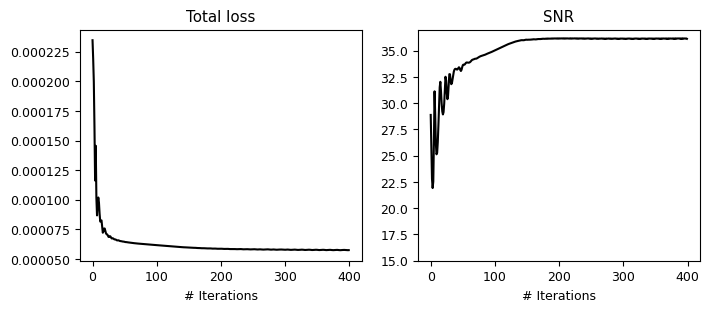

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(epoch_losses, 'k')
ax[0].set_xlabel('# Iterations')
# ax[0].set_ylim(0.0005, 0.0030)
ax[0].set_title('Total loss')
ax[1].plot(snrs, 'k')
ax[1].set_xlabel('# Iterations')
ax[1].set_ylim(15,37)
ax[1].set_title('SNR')
print(np.max(snrs))

(<Figure size 1000x800 with 4 Axes>,
 (<AxesSubplot:xlabel='x samples', ylabel='t samples'>,
  <AxesSubplot:ylabel='y samples'>,
  <AxesSubplot:xlabel='y samples'>))

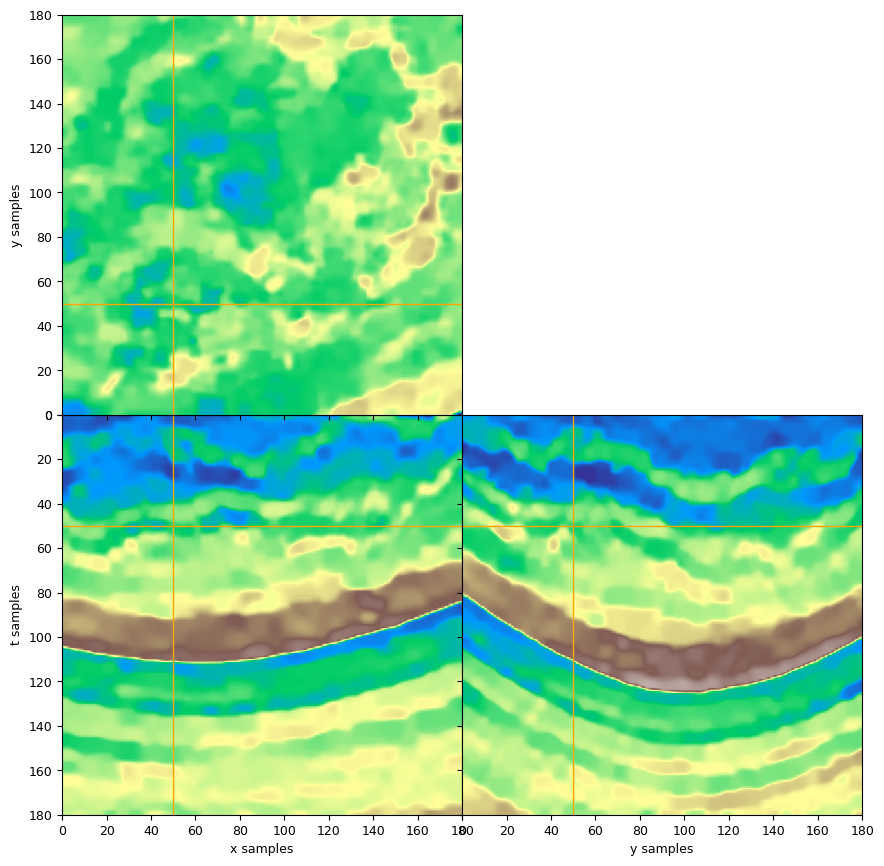

In [7]:
net.eval()
with torch.no_grad():
    delta_model = net(coords.to(device))
    model_ = delta_model.squeeze(1) + mback.ravel().to(device)

i, j, k = 50, 50, 50
model_cpu= model_.reshape(*dims).detach().cpu()
explode_volume(np.exp(model_cpu), i, j, k, figsize=(10, 8), 
               cmap='terrain', vmin=vmin, vmax=vmax)

In [8]:
# 20*(1.06**16), 180/4, (180/4)*.6